## Imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # for nice progress bars
import math # plots
np.random.seed(20030403)



In [51]:
np.random.seed(20030403)
np.set_printoptions(precision=2) # 2 decimal places for numpy

## Datasets

In [52]:
square_large_train = pd.read_csv('../regression/square-large-training.csv')
steps_large_train = pd.read_csv('../regression/steps-small-training.csv')
multimodal_large_train = pd.read_csv('../regression/multimodal-large-training.csv')

square_large_test = pd.read_csv('../regression/square-large-test.csv')
steps_large_test = pd.read_csv('../regression/steps-small-test.csv')
multimodal_large_test = pd.read_csv('../regression/multimodal-large-test.csv')

datasets = [square_large_train, steps_large_train, multimodal_large_train, square_large_test, steps_large_test, multimodal_large_test]


## Helper Functions and classes

In [53]:
def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def sigmoidal(x, derivative=False):
    x_safe = np.clip(x, -500, 500) # aby nie bylo overflow
    s = 1 / (1 + np.exp(-x_safe))
    if derivative:
        return s * (1 - s)
    return s

def linear(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    return x

In [54]:
def plot_data(data_x, data_y):
    plt.figure(figsize=(8, 6))
    plt.scatter(data_x, data_y, color='blue', label='Dane treningowe')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Wykres danych treningowych")
    plt.legend()
    plt.grid()
    plt.show()

In [55]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.sd = None
    
    def fit(self, data): # Compute the mean and standard deviation along the feature axis (axis=0)
        self.mean = np.mean(data, axis=0)
        self.sd = np.std(data, axis=0)
    
    def transform(self, data): # Scale the data using the computed mean and sd
        return (data - self.mean) / self.sd
    
    def fit_transform(self, data): # Fit to the data, then transform it
        self.fit(data)
        return self.transform(data)
    
    def inverse_transform(self, data): # reverse the scaling
        return data * self.sd + self.mean

# Data plots

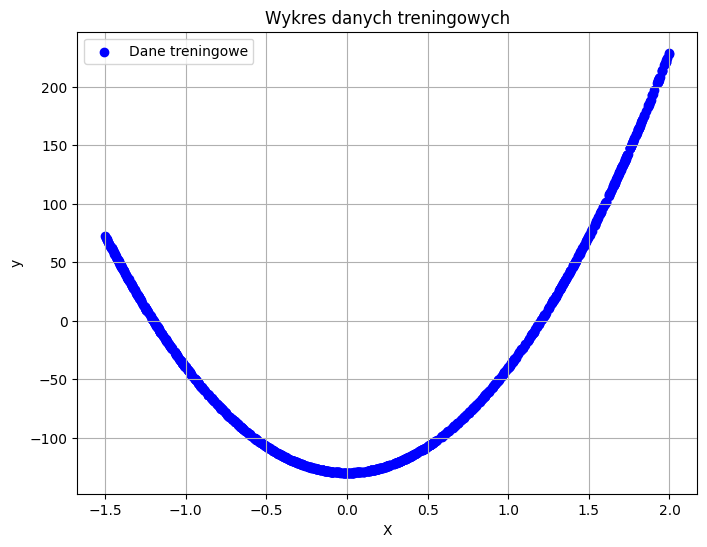

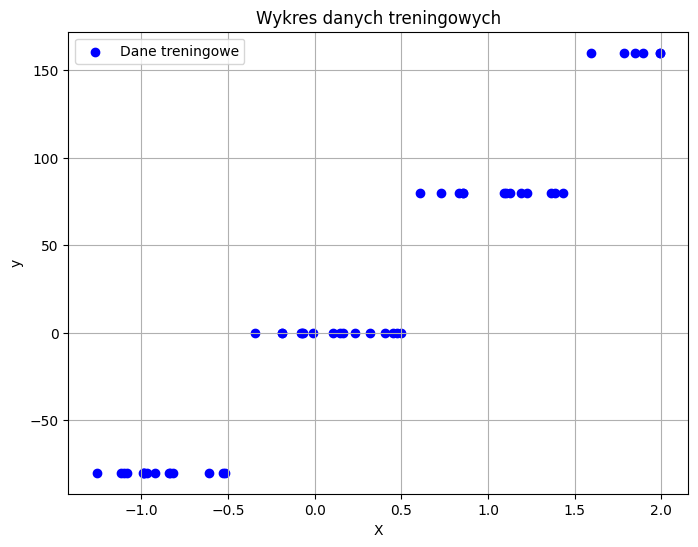

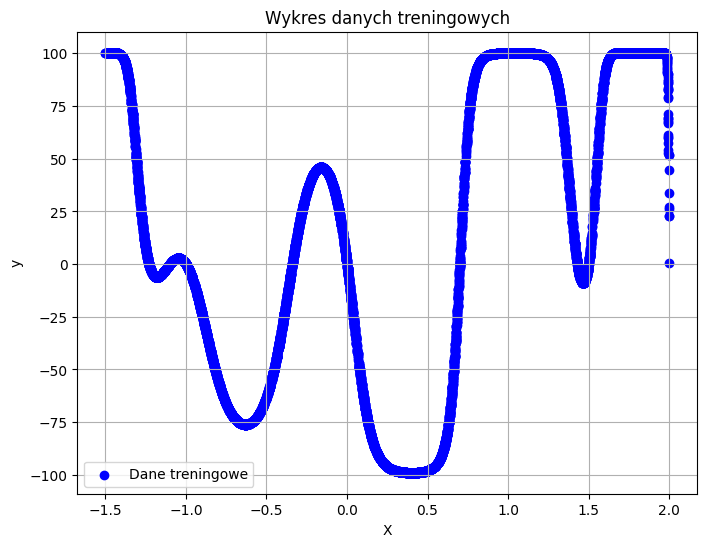

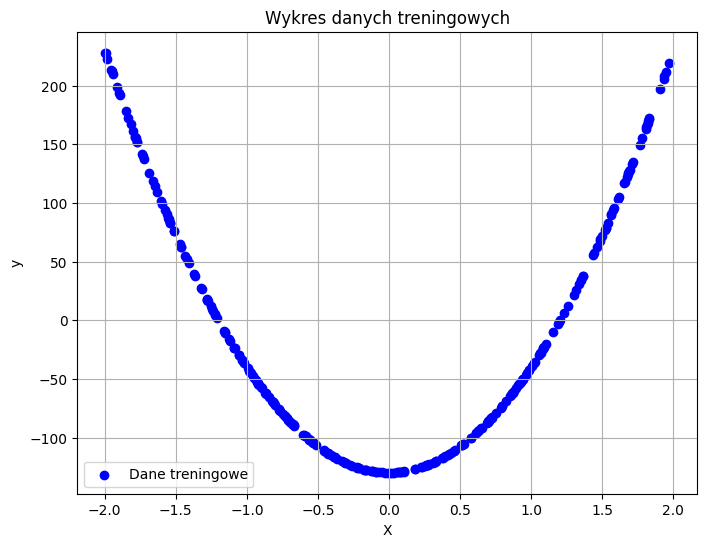

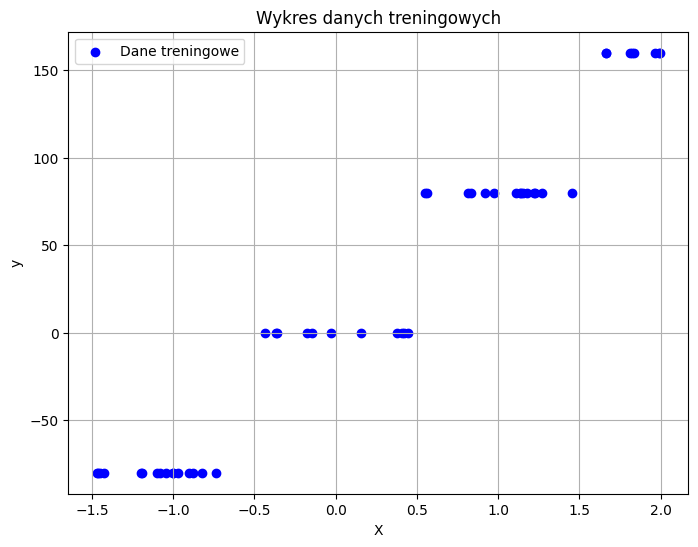

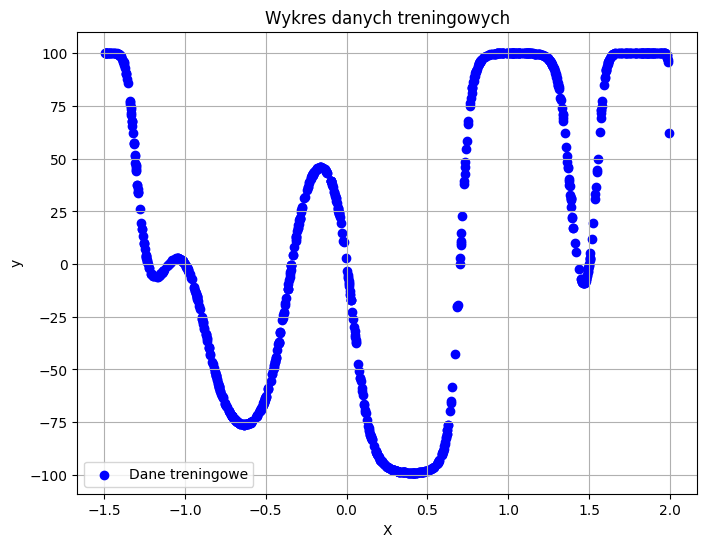

In [56]:
for dataset in datasets:
    plot_data(dataset['x'], dataset['y'])

# MLP backprop + moment + normalizacja

In [153]:
class MLPBackprop:
    def __init__(self, layers, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='sigmoid', 
                 starting_weights=None, 
                 starting_biases=None,
                 momentum=0.0,            
                 rmsprop_decay=0.0,   
                 rmsprop_epsilon=1e-8):     
        
        self.layers = layers
        self.weights = []
        self.biases = []
        self.print_epoch = True
        self.weight_history = []
        self.bias_history = []
        activation_functions = {"relu": relu, "sigmoid": sigmoidal, "linear": linear}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Invalid hidden activation function, choose from:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Invalid output activation function, choose from:", activation_functions)
        
        self.momentum = momentum
        self.rmsprop_decay = rmsprop_decay
        self.rmsprop_epsilon = rmsprop_epsilon
        
        for i in range(len(self.layers) - 1):
            n_input = self.layers[i]
            n_output = self.layers[i + 1]
            
            activation_function = self.hidden_activation_function if i < len(self.layers) - 2 else self.output_activation_function
            
            if activation_function == sigmoidal:  # Xavier initialization 
                weight_matrix = np.random.normal(0, np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
            elif activation_function == relu:  # He initialization
                weight_matrix = np.random.uniform(0, np.sqrt(2 / n_input), size=(n_input, n_output))
            else:
                weight_matrix = np.random.randn(n_input, n_output)
            self.weights.append(weight_matrix)
            self.biases.append(np.zeros((1, n_output)))
        
        if self.momentum > 0:
            self.weight_velocities = [np.zeros_like(w) for w in self.weights]
            self.bias_velocities = [np.zeros_like(b) for b in self.biases]
        
        if self.rmsprop_decay > 0:
            self.weight_cache = [np.zeros_like(w) for w in self.weights]
            self.bias_cache = [np.zeros_like(b) for b in self.biases]
    
    def forward(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.z_values = []
        self.activations = [X]
        activation = X
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            activation = self.hidden_activation_function(z)
            self.activations.append(activation)
            
        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        output = self.output_activation_function(z)
        self.activations.append(output)
        return output
    
    def predict(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        return self.forward(X)
    
    def backpropagation(self, X, y, learning_rate=0.01):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        N = X.shape[0]
        output = self.forward(X)
        
        d_loss = (output - y) / N
        
        if self.output_activation_function == sigmoidal or self.output_activation_function == relu:
            delta = d_loss * self.output_activation_function(self.z_values[-1], derivative=True)
        else:  # linear output
            delta = d_loss
            
        deltas = [delta]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.hidden_activation_function(self.z_values[i-1], derivative=True)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            grad_w = np.dot(self.activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)
            
            if self.rmsprop_decay > 0:
                self.weight_cache[i] = self.rmsprop_decay * self.weight_cache[i] + (1 - self.rmsprop_decay) * (grad_w ** 2)
                self.bias_cache[i] = self.rmsprop_decay * self.bias_cache[i] + (1 - self.rmsprop_decay) * (grad_b ** 2)
                adjusted_grad_w = grad_w / (np.sqrt(self.weight_cache[i]) + self.rmsprop_epsilon)
                adjusted_grad_b = grad_b / (np.sqrt(self.bias_cache[i]) + self.rmsprop_epsilon)
            else:
                adjusted_grad_w = grad_w
                adjusted_grad_b = grad_b
            
            if self.momentum > 0:
                self.weight_velocities[i] = self.momentum * self.weight_velocities[i] + learning_rate * adjusted_grad_w
                self.bias_velocities[i] = self.momentum * self.bias_velocities[i] + learning_rate * adjusted_grad_b
                self.weights[i] -= self.weight_velocities[i]
                self.biases[i] -= self.bias_velocities[i]
            else:
                self.weights[i] -= learning_rate * adjusted_grad_w
                self.biases[i] -= learning_rate * adjusted_grad_b

    def train(self, X, y, epochs=1000, learning_rate=0.02, batch_size=0):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        best_loss = np.inf
        self.loss_history = []
        best_weights = None
        best_biases = None
        self.weight_history = []

        progress_bar = tqdm(range(epochs), desc="Training")

        for epoch in progress_bar:
            if batch_size == 0:
                self.backpropagation(X, y, learning_rate)
            else:
                indices = np.random.permutation(X.shape[0])
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                for i in range(0, X.shape[0], batch_size):
                    X_batch = X_shuffled[i:i + batch_size]
                    y_batch = y_shuffled[i:i + batch_size]
                    self.backpropagation(X_batch, y_batch, learning_rate)
            
            predictions = self.predict(X)
            loss = np.mean(np.square(y - predictions))
            
            if loss < best_loss:
                best_loss = loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
            
            loss = np.mean(np.square(y - self.predict(X)))
            self.loss_history.append(loss)
            current_weights = [w.copy() for w in self.weights]
            current_biases = [b.copy() for b in self.biases]
            self.weight_history.append(current_weights)
            self.bias_history.append(current_biases)
            
            progress_bar.set_postfix(loss=f"{loss:.6f}")
        
        self.weights = best_weights
        self.biases = best_biases
        print(f'Best loss: {best_loss}')

    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def plot_history(self, figsize=(15, 10), save_path=None, max_neurons_per_plot=10):
        if not self.weight_history:
            raise ValueError("No weight history available. Train the network first.")
        
        num_layers = len(self.weights)
        num_epochs = len(self.weight_history)
        epochs = np.arange(num_epochs)
        
        total_subplots = num_layers * 2 + 1
        
        cols = min(2, total_subplots)
        rows = math.ceil(total_subplots / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
        if total_subplots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        subplot_idx = 0
        
        ax_loss = axes[subplot_idx]
        subplot_idx += 1
        
        ax_loss.plot(epochs, self.loss_history, '-', linewidth=2, label='Training Loss')
        if hasattr(self, 'val_loss_history') and self.val_loss_history:
            ax_loss.plot(epochs, self.val_loss_history, '-', linewidth=2, label='Validation Loss')
        
        ax_loss.set_title('Loss History')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss (MSE)')
        ax_loss.grid(True, alpha=0.3)
        ax_loss.legend()
        
        for layer_idx in range(num_layers):
            input_size, output_size = self.weights[layer_idx].shape
            ax_weights = axes[subplot_idx]
            subplot_idx += 1
            
            total_weights = input_size * output_size
            if total_weights > max_neurons_per_plot:
                indices_flat = np.random.choice(total_weights, max_neurons_per_plot, replace=False)
                indices = [(idx // output_size, idx % output_size) for idx in indices_flat]
            else:
                indices = [(i, j) for i in range(input_size) for j in range(output_size)]
            
            for i, j in indices:
                weight_values = [self.weight_history[epoch][layer_idx][i, j] for epoch in range(num_epochs)]
                ax_weights.plot(epochs, weight_values, '-', linewidth=1, 
                            label=f'w_{i+1},{j+1}' if total_weights <= 20 else None)
            
            ax_weights.set_title(f'Layer {layer_idx+1}: Weights')
            ax_weights.set_xlabel('Epoch')
            ax_weights.set_ylabel('Weight Value')
            ax_weights.grid(True, alpha=0.3)
            if total_weights <= 20:
                ax_weights.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            ax_biases = axes[subplot_idx]
            subplot_idx += 1
            
            bias_size = self.biases[layer_idx].shape[1]
            if bias_size > max_neurons_per_plot:
                bias_indices = np.random.choice(bias_size, max_neurons_per_plot, replace=False)
            else:
                bias_indices = range(bias_size)
            
            for j in bias_indices:
                bias_values = [self.bias_history[epoch][layer_idx][0, j] for epoch in range(num_epochs)]
                ax_biases.plot(epochs, bias_values, '-', linewidth=1, 
                            label=f'b_{j+1}' if bias_size <= 20 else None)
            
            ax_biases.set_title(f'Layer {layer_idx+1}: Biases')
            ax_biases.set_xlabel('Epoch')
            ax_biases.set_ylabel('Bias Value')
            ax_biases.grid(True, alpha=0.3)
            if bias_size <= 20:
                ax_biases.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        for i in range(subplot_idx, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        plt.show()


# Testing on data

In [59]:
def plot_comparison(X_test, y_test, y_pred):
    plt.scatter(X_test, y_test, label="True Data")
    plt.scatter(X_test, y_pred, label="Predicted Data")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()

## square_large_train

Training: 100%|██████████| 3000/3000 [00:17<00:00, 171.84it/s, loss=0.001085]


Best loss: 0.00027549006447698986
MSE: 68.13949576135651


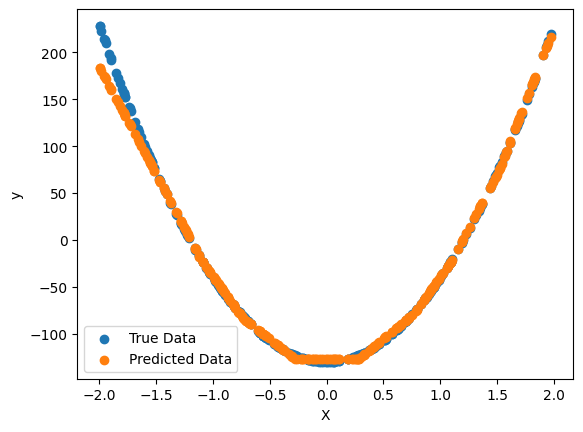

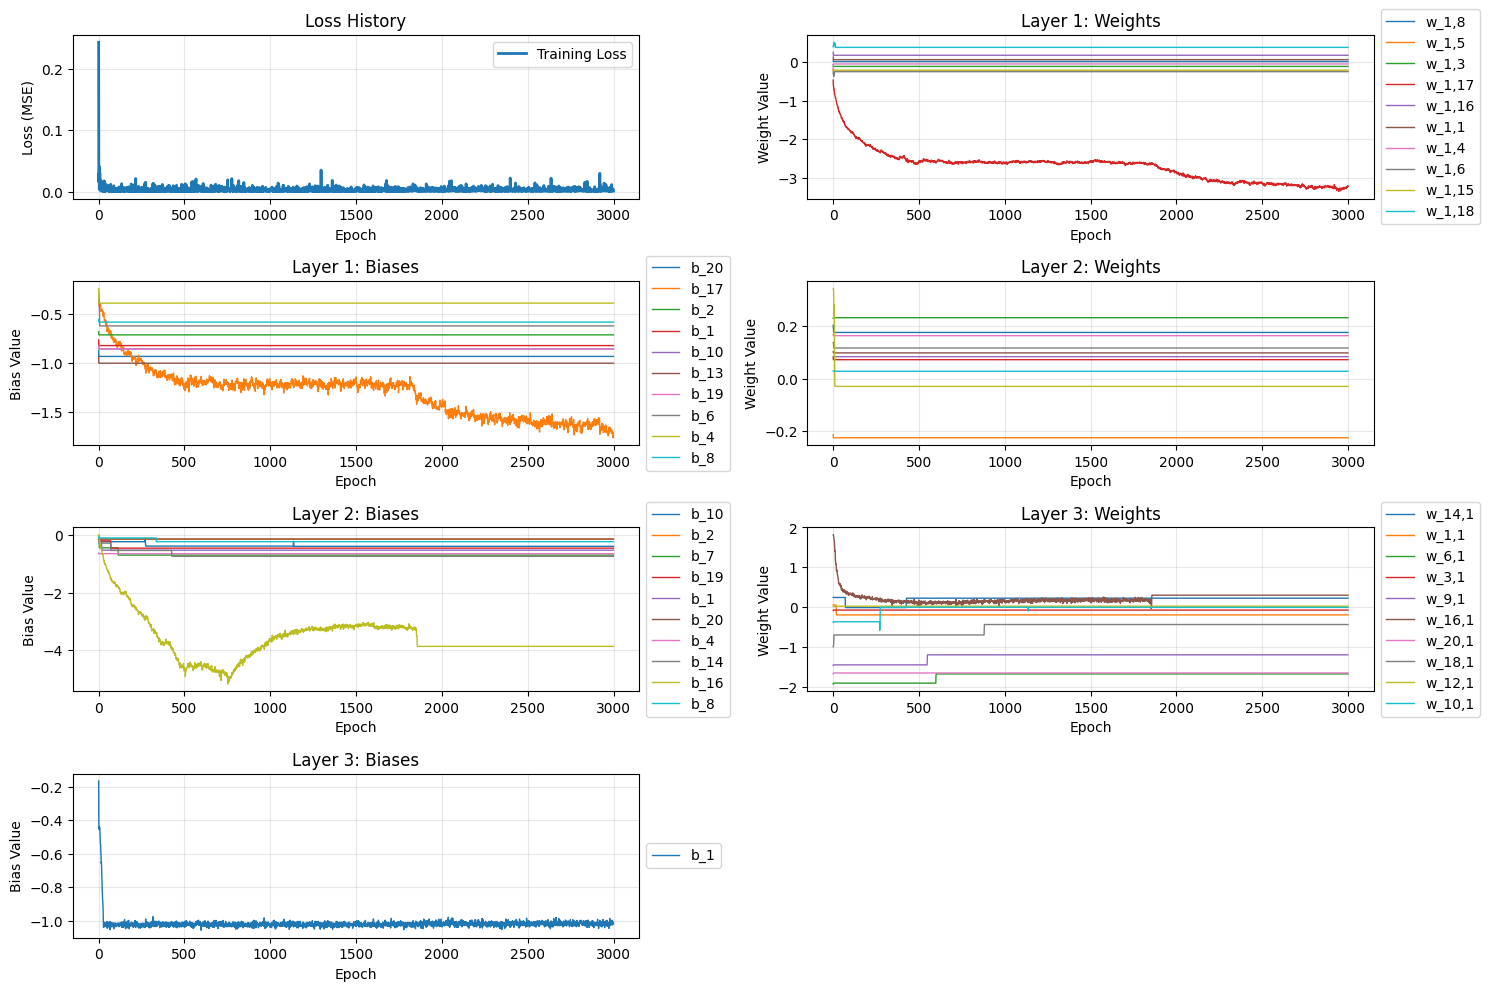

In [ ]:
X_train = square_large_train.iloc[:, 1].values.reshape(-1, 1)
y_train = square_large_train.iloc[:, 2].values.reshape(-1, 1)
X_test = square_large_test.iloc[:, 1].values.reshape(-1, 1)
y_test = square_large_test.iloc[:, 2].values.reshape(-1, 1)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

NN = MLPBackprop([1, 10, 10, 1], output_activation_function = 'linear')

NN = MLPBackprop(
    [1, 20, 20, 1],
    hidden_activation_function="relu",
    output_activation_function="linear",
    momentum=0.9,
    rmsprop_decay=0.9,
    rmsprop_epsilon=1e-8
)
NN.train(X_train_scaled, y_train_scaled, epochs=3000, batch_size=30, learning_rate=0.008)

y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)

NN.plot_history()


## Steps large

Training: 100%|██████████| 50000/50000 [00:58<00:00, 860.58it/s, loss=0.000028]


Best loss: 5.676880776359886e-07
MSE: 88.14853622130732


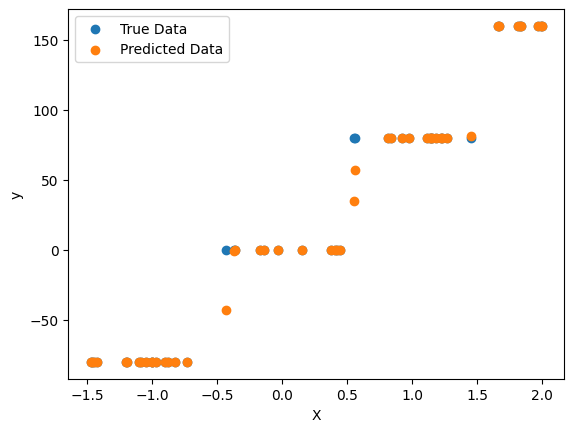

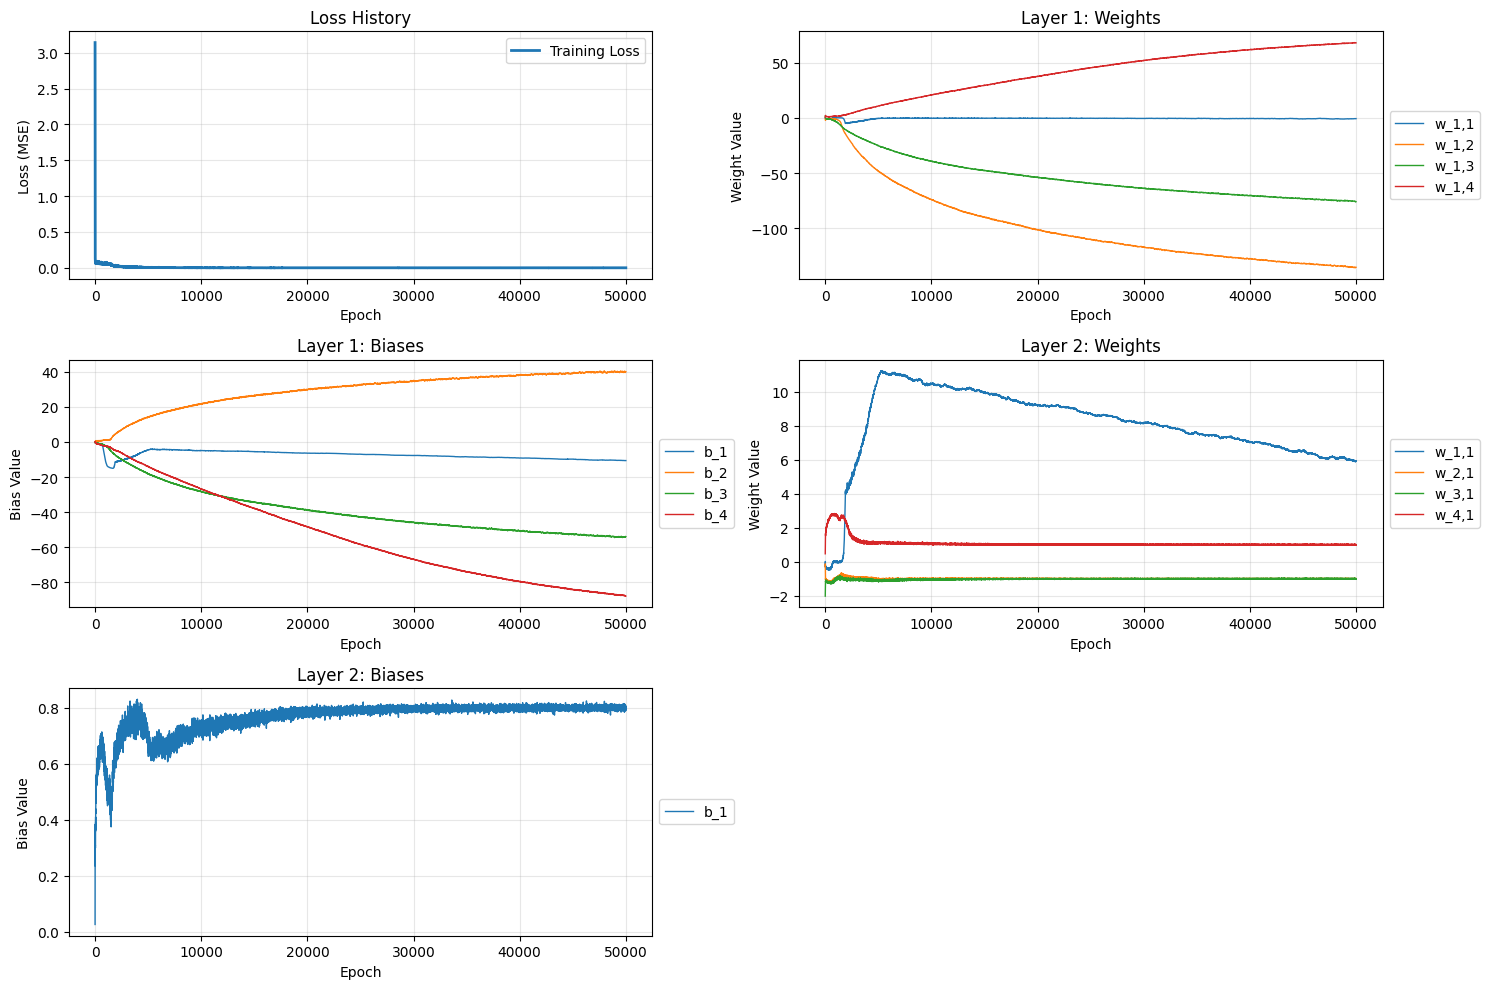

In [ ]:
X_train = steps_large_train.iloc[:, 1].values.reshape(-1, 1)
y_train = steps_large_train.iloc[:, 2].values.reshape(-1, 1)
X_test = steps_large_test.iloc[:, 1].values.reshape(-1, 1)
y_test = steps_large_test.iloc[:, 2].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)


NN = MLPBackprop(
    [1, 4, 1],
    hidden_activation_function="sigmoid",
    output_activation_function="linear",
    momentum=0.9,           
    rmsprop_decay=0.9,
    rmsprop_epsilon=1e-8 
)

NN.train(X_train_scaled, y_train_scaled, epochs=50000, learning_rate=0.005, batch_size=45)
y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)
NN.plot_history()


## Multimodal large

Training: 100%|██████████| 2000/2000 [01:45<00:00, 18.89it/s, loss=0.001418]


Best loss: 0.0014093016953118575
MSE: 3.126924163458468


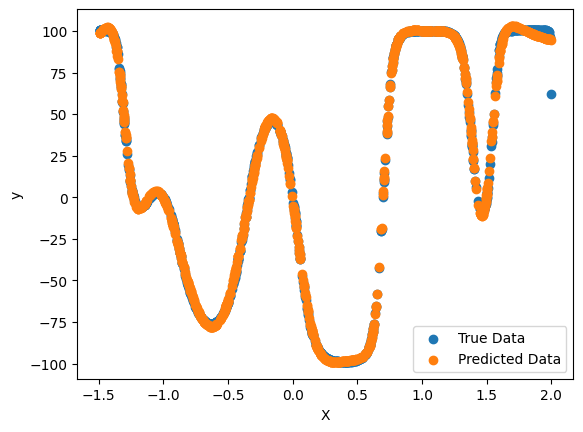

In [106]:
X_train = multimodal_large_train.iloc[:, 0].values.reshape(-1, 1)
y_train = multimodal_large_train.iloc[:, 1].values.reshape(-1, 1)
X_test = multimodal_large_test.iloc[:, 0].values.reshape(-1, 1)
y_test = multimodal_large_test.iloc[:, 1].values.reshape(-1, 1)



scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)


NN = MLPBackprop([1, 10, 10, 1], hidden_activation_function='sigmoid', output_activation_function='linear')
NN.train(X_train_scaled, y_train_scaled, epochs=2000, learning_rate=0.2, batch_size=20)


y_pred_scaled = NN.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
print("MSE:", mse)

plot_comparison(X_test, y_test, y_pred)



# Porównanie zbieżności

Training: 100%|██████████| 100/100 [00:00<00:00, 773.19it/s, loss=0.045510]


Best loss: 0.045348087695860836


Training: 100%|██████████| 100/100 [00:00<00:00, 712.21it/s, loss=0.046276]


Best loss: 0.04525450397893767


Training: 100%|██████████| 100/100 [00:00<00:00, 652.75it/s, loss=0.060271]


Best loss: 0.051800161183065595


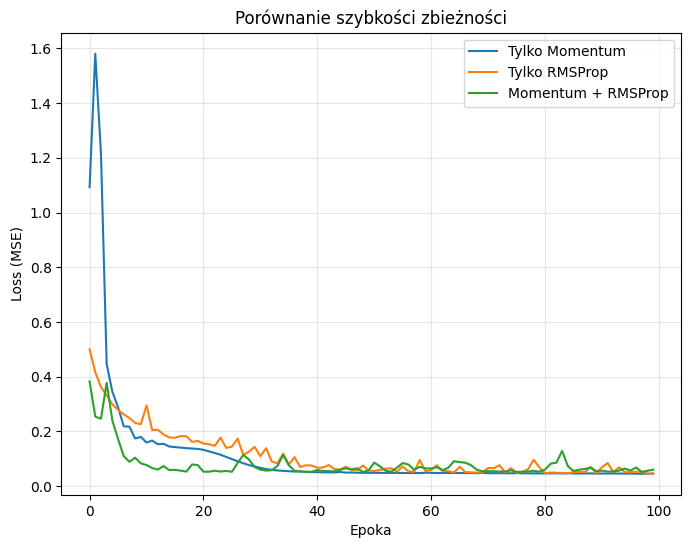

In [ ]:
def train_and_get_loss(momentum, rmsprop_decay, label, 
                       hidden_activation="relu",
                       output_activation="linear",
                       epochs=100, learning_rate=0.01, batch_size=10):
    """
    Tworzy sieć MLPBackprop z zadanym momentem i RMSProp, 
    trenuje ją i zwraca historię strat (loss_history).
    """
    NN = MLPBackprop(
        [1, 10, 1],
        hidden_activation_function=hidden_activation,
        output_activation_function=output_activation,
        momentum=momentum,
        rmsprop_decay=rmsprop_decay,
        rmsprop_epsilon=1e-8
    )
    
    NN.train(
        X_train_scaled, 
        y_train_scaled, 
        epochs=epochs, 
        learning_rate=learning_rate, 
        batch_size=batch_size
    )
    
    return NN.loss_history

# Trening tylko z momentem
loss_momentum = train_and_get_loss(
    momentum=0.9, # wl.
    rmsprop_decay=0.0,  # wyl.
    label="Momentum Only"
)

# Trening tylko z RMSProp
loss_rmsprop = train_and_get_loss(
    momentum=0.0, # wyl.
    rmsprop_decay=0.9,  # wl.
    label="RMSProp Only"
)

# Trening z momentem i rmsprop
loss_momentum_rmsprop = train_and_get_loss(
    momentum=0.9,
    rmsprop_decay=0.9,
    label="Momentum + RMSProp"
)

# Porównanie krzywych zbieżności
plt.figure(figsize=(8,6))
plt.plot(loss_momentum, label="Tylko Momentum")
plt.plot(loss_rmsprop, label="Tylko RMSProp")
plt.plot(loss_momentum_rmsprop, label="Momentum + RMSProp")
plt.xlabel("Epoka")
plt.ylabel("Loss (MSE)")
plt.title("Porównanie szybkości zbieżności")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()